In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2]:
#Read salary information for occupations for all areas into a dataframe
salary_df = pd.read_excel('../data/raw/MSA_M2020_dl.xlsx', sheet_name = 'MSA_M2020_dl')

In [3]:
salary_df.head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,16.41,24.82,36.23,18990,23710,34130,51620,75370,NaN,NaN
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,36.37,51.68,73.88,36150,55620,75640,107500,153670,NaN,NaN
2,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,32.96,50.11,72.93,26350,49960,68550,104230,151700,NaN,NaN
3,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2022,Sales Managers,...,52.41,68.01,#,54560,74680,109000,141460,#,NaN,NaN
4,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2030,Public Relations and Fundraising Managers,...,36.24,41.23,83.81,59710,68180,75380,85760,174320,NaN,NaN


In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140051 entries, 0 to 140050
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AREA          140051 non-null  int64  
 1   AREA_TITLE    140051 non-null  object 
 2   AREA_TYPE     140051 non-null  int64  
 3   PRIM_STATE    140051 non-null  object 
 4   NAICS         140051 non-null  int64  
 5   NAICS_TITLE   140051 non-null  object 
 6   I_GROUP       140051 non-null  object 
 7   OWN_CODE      140051 non-null  int64  
 8   OCC_CODE      140051 non-null  object 
 9   OCC_TITLE     140051 non-null  object 
 10  O_GROUP       140051 non-null  object 
 11  TOT_EMP       140051 non-null  object 
 12  EMP_PRSE      140051 non-null  object 
 13  JOBS_1000     140051 non-null  object 
 14  LOC_QUOTIENT  140051 non-null  object 
 15  PCT_TOTAL     0 non-null       float64
 16  H_MEAN        140051 non-null  object 
 17  A_MEAN        140051 non-null  object 
 18  MEAN

Right away, we can see there are zero non-null values in PCT_TOTAL and only 215 in HOURLY and 7,199 in the ANNUAL (out of 140,051).

In [5]:
# Create a profile report of salary_df
report = salary_df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)

report.to_widgets()

PCT_TOTAL is missing 100 percent of its values and we can immediately drop this column. HOURLY and ANNUAL are missing over 99 and 95 percent respectively. Let's see whats going on there!

The fields HOURLY and ANNUL are defined as follows:

annual - Contains "TRUE" if only annual wages are released. The OEWS program releases only annual wages for some occupations that typically work fewer than 2,080 hours per year, but are paid on an annual basis, such as teachers, pilots, and athletes.

hourly - Contains "TRUE" if only hourly wages are released. The OEWS program releases only hourly wages for some occupations that typically work fewer than 2,080 hours per year and are paid on an hourly basis, such as actors, dancers, and musicians and singers.

The HOURLY seems relevent to a few occuptions (only 215, and less than 0.2 percent). ANNUAL has more values (7,199) yet it is still missing nearly 95 percent of it's values.  

In [6]:
# Let's look at occupations where their HOURLY value is reported
hourly_missing = salary_df[salary_df['HOURLY'].notna()].groupby('OCC_TITLE')
hourly_missing['OCC_TITLE'].nunique()

OCC_TITLE
Actors                                                                   1
Dancers                                                                  1
Miscellaneous Entertainers and Performers, Sports and Related Workers    1
Musicians and Singers                                                    1
Name: OCC_TITLE, dtype: int64

Looks like there are only 4 occupation titles this column applies to. I feel safe dropping it. There is a hardly any information here.

In [7]:
# Trying the same thing for ANNUAL
annual_missing = salary_df[salary_df['ANNUAL'].notna()].groupby('OCC_TITLE')

annual_missing['OCC_TITLE'].nunique()

OCC_TITLE
Agricultural Sciences Teachers, Postsecondary                               1
Airline Pilots, Copilots, and Flight Engineers                              1
Anthropology and Archeology Teachers, Postsecondary                         1
Architecture Teachers, Postsecondary                                        1
Area, Ethnic, and Cultural Studies Teachers, Postsecondary                  1
Art, Drama, and Music Teachers, Postsecondary                               1
Athletes and Sports Competitors                                             1
Athletic Trainers                                                           1
Atmospheric, Earth, Marine, and Space Sciences Teachers, Postsecondary      1
Biological Science Teachers, Postsecondary                                  1
Business Teachers, Postsecondary                                            1
Career/Technical Education Teachers, Middle School                          1
Career/Technical Education Teachers, Secondary School 

In [8]:
# How many distinct occupation titles are not null for ANNUAL? 
annual_missing['OCC_TITLE'].nunique().sum()

58

58 unique occupation titles have a non_null value for ANNUAL. Should we keep these columns for now? Our problem statement is interested in total income of each occupation for cities around the country and the skill base that affects the income. Whether the income is reported only annually or hourly is probably not relevent! 

In [9]:
# Drop the above three columns (PCT_TOTAL, ANNUAL, HOURLY)
salary_df = salary_df.drop(columns=['PCT_TOTAL','ANNUAL','HOURLY'])

In [10]:
salary_df.columns

Index(['AREA', 'AREA_TITLE', 'AREA_TYPE', 'PRIM_STATE', 'NAICS', 'NAICS_TITLE',
       'I_GROUP', 'OWN_CODE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP', 'TOT_EMP',
       'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN', 'A_MEAN',
       'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90',
       'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90'],
      dtype='object')

From the report, there are a total of 18 unsupported variables. 

In [11]:
# The following columns were rejected
rejected = report.get_rejected_variables()
print(rejected)

{'H_PCT90', 'TOT_EMP', 'A_PCT75', 'H_PCT10', 'PCT_TOTAL', 'H_PCT25', 'A_PCT90', 'OWN_CODE', 'NAICS_TITLE', 'H_PCT75', 'A_PCT10', 'I_GROUP', 'H_MEAN', 'EMP_PRSE', 'A_MEAN', 'H_MEDIAN', 'NAICS', 'A_PCT25', 'AREA_TYPE', 'LOC_QUOTIENT', 'MEAN_PRSE', 'JOBS_1000', 'A_MEDIAN'}


I would like to be able to get a detailed report on these fields. We already dropped PCT_TOTAL. AREA_TYPE and NAICS are a constant value for all the rows (respectively. NAICS_TITLE and I_GROUP only have 'cross_industry' as their only value and OWN_CODE has a constant value of 1235. Having a constant value for each field gives us no information whatsoever and we can safely drop these columns

In [12]:
# Drop columns AREA, NAICS, NAICS_TITLE, I_GROUP, OWN_CODE
salary_df = salary_df.drop(columns=['AREA_TYPE','NAICS','NAICS_TITLE','I_GROUP','OWN_CODE'])

In [13]:
salary_df.columns

Index(['AREA', 'AREA_TITLE', 'PRIM_STATE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP',
       'TOT_EMP', 'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN', 'A_MEAN',
       'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90',
       'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90'],
      dtype='object')

In [14]:
salary_df.dtypes

AREA             int64
AREA_TITLE      object
PRIM_STATE      object
OCC_CODE        object
OCC_TITLE       object
O_GROUP         object
TOT_EMP         object
EMP_PRSE        object
JOBS_1000       object
LOC_QUOTIENT    object
H_MEAN          object
A_MEAN          object
MEAN_PRSE       object
H_PCT10         object
H_PCT25         object
H_MEDIAN        object
H_PCT75         object
H_PCT90         object
A_PCT10         object
A_PCT25         object
A_MEDIAN        object
A_PCT75         object
A_PCT90         object
dtype: object

Every columns with the exception of AREA is of object type! That shouldn't be the case as if we look at our dataframe, there are a lot of numerical values in it. Only the columns with O_GROUP,  OCC_TITLE, AREA_TITLE, PRIM_STATE should be the only non-numeric fields. 

In [15]:
# Remove dash from OCC_CODE before converting type
salary_df['OCC_CODE'] = salary_df['OCC_CODE'].str.replace('-','')
salary_df['OCC_CODE']

0         000000
1         110000
2         111021
3         112022
4         112030
           ...  
140046    537063
140047    537064
140048    537065
140049    537081
140050    537199
Name: OCC_CODE, Length: 140051, dtype: object

In [16]:
# People who make more than $208,000 a year/$100 an hour
salary_df['OCC_TITLE'][(salary_df['H_MEAN']=='#') | (salary_df['A_MEAN']=='#')].unique()

array(['Surgeons, Except Ophthalmologists', 'Anesthesiologists',
       'Physicians, All Other; and Ophthalmologists, Except Pediatric',
       'Obstetricians and Gynecologists',
       'General Internal Medicine Physicians',
       'Agents and Business Managers of Artists, Performers, and Athletes',
       'Dentists, General', 'Orthodontists', 'Psychiatrists',
       'Dentists, All Other Specialists', 'Family Medicine Physicians',
       'Oral and Maxillofacial Surgeons'], dtype=object)

\*  = indicates that a wage estimate is not available	
\**  = indicates that an employment estimate is not available	
\#  = indicates a wage equal to or greater than \$100 per hour or \$208,000 per year 	

I don't want to lose information about those highest earning occupations so before converting object types to float, I'll extract these for later use for imputing values

In [17]:
# Dataframe of highest earning occupations (above $100 an hour of $208,000 a year)
top_income = salary_df[(salary_df['H_MEAN']=='#') | (salary_df['A_MEAN']=='#')]
top_income

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
8750,12540,"Bakersfield, CA",CA,291248,"Surgeons, Except Ophthalmologists",detailed,**,**,**,**,...,#,#,#,#,#,#,#,#,#,#
16594,15380,"Buffalo-Cheektowaga-Niagara Falls, NY",NY,291211,Anesthesiologists,detailed,220,46.9,0.434,2.11,...,#,#,#,#,#,#,#,#,#,#
17928,15980,"Cape Coral-Fort Myers, FL",FL,291211,Anesthesiologists,detailed,**,**,**,**,...,#,#,#,#,#,#,#,#,#,#
21068,16740,"Charlotte-Concord-Gastonia, NC-SC",NC,291211,Anesthesiologists,detailed,**,**,**,**,...,#,#,#,#,#,#,#,#,#,#
21074,16740,"Charlotte-Concord-Gastonia, NC-SC",NC,291248,"Surgeons, Except Ophthalmologists",detailed,100,22.5,0.082,0.3,...,#,#,#,#,#,#,#,#,#,#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135424,74500,"Leominster-Gardner, MA",MA,291215,Family Medicine Physicians,detailed,**,**,**,**,...,#,#,#,#,#,#,#,#,#,#
135425,74500,"Leominster-Gardner, MA",MA,291228,"Physicians, All Other; and Ophthalmologists, E...",detailed,90,44.8,1.779,0.66,...,#,#,#,#,#,#,#,#,#,#
135964,74950,"Manchester, NH",NH,291211,Anesthesiologists,detailed,40,48.7,0.378,1.84,...,#,#,#,#,#,#,#,#,#,#
135968,74950,"Manchester, NH",NH,291248,"Surgeons, Except Ophthalmologists",detailed,70,23.8,0.611,2.24,...,#,#,#,#,#,#,#,#,#,#


In [18]:
# List of fields to convert to numeric type
convert_to_float = ['OCC_CODE', 'TOT_EMP', 'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN',
        'A_MEAN','MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75',
        'H_PCT90', 'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90']

salary_df[convert_to_float] = salary_df[convert_to_float].apply(pd.to_numeric, errors='coerce')

salary_df.dtypes

AREA              int64
AREA_TITLE       object
PRIM_STATE       object
OCC_CODE          int64
OCC_TITLE        object
O_GROUP          object
TOT_EMP         float64
EMP_PRSE        float64
JOBS_1000       float64
LOC_QUOTIENT    float64
H_MEAN          float64
A_MEAN          float64
MEAN_PRSE       float64
H_PCT10         float64
H_PCT25         float64
H_MEDIAN        float64
H_PCT75         float64
H_PCT90         float64
A_PCT10         float64
A_PCT25         float64
A_MEDIAN        float64
A_PCT75         float64
A_PCT90         float64
dtype: object

In [19]:
# Run a new roport
profile_report = salary_df.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/bls.html")

profile_report.to_widgets()

### Categorical

In [20]:
salary_df.select_dtypes('object')

,AREA_TITLE,PRIM_STATE,OCC_TITLE,O_GROUP
0,"Abilene, TX",TX,All Occupations,total
1,"Abilene, TX",TX,Management Occupations,major
2,"Abilene, TX",TX,General and Operations Managers,detailed
3,"Abilene, TX",TX,Sales Managers,detailed
4,"Abilene, TX",TX,Public Relations and Fundraising Managers,detailed
...,...,...,...,...
140046,"Worcester, MA-CT",MA,Machine Feeders and Offbearers,detailed
140047,"Worcester, MA-CT",MA,"Packers and Packagers, Hand",detailed
140048,"Worcester, MA-CT",MA,Stockers and Order Fillers,detailed
140049,"Worcester, MA-CT",MA,Refuse and Recyclable Material Collectors,detailed


From the report we can see there are no missing values for our categorical variables.

In [21]:
# Unique states
print(salary_df['PRIM_STATE'].nunique()) 
print(salary_df['PRIM_STATE'].unique()) 
salary_df['PRIM_STATE'].value_counts().head() 

52
['TX' 'PR' 'OH' 'GA' 'OR' 'NY' 'NM' 'LA' 'PA' 'IA' 'AK' 'MI' 'AL' 'WI'
 'NC' 'NJ' 'CA' 'MD' 'WV' 'WA' 'MT' 'ND' 'VA' 'IL' 'IN' 'ID' 'CO' 'KY'
 'FL' 'MO' 'NV' 'WY' 'SC' 'TN' 'DE' 'MN' 'OK' 'AR' 'AZ' 'NE' 'MS' 'HI'
 'KS' 'UT' 'SD' 'DC' 'ME' 'MA' 'CT' 'VT' 'NH' 'RI']


CA    10713
TX     9320
FL     8318
PA     6406
NC     5420
Name: PRIM_STATE, dtype: int64

In [22]:
# How many unique AREA_TITLES?
print(salary_df['AREA_TITLE'].nunique())
salary_df['AREA_TITLE'].value_counts()

396


New York-Newark-Jersey City, NY-NJ-PA          756
Los Angeles-Long Beach-Anaheim, CA             741
Chicago-Naperville-Elgin, IL-IN-WI             741
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD    716
Boston-Cambridge-Nashua, MA-NH                 715
                                              ... 
Mayaguez, PR                                   147
Arecibo, PR                                    140
Hinesville, GA                                 115
San German, PR                                  98
Guayama, PR                                     67
Name: AREA_TITLE, Length: 396, dtype: int64

396 unique AREA_TITLE (same as AREA which is code for each AREA_TITLE). But there are state labels included. There are multiple state labels included for metropolitan areas. 

In [23]:
# AREA_TITLES split into two columns
area_split = salary_df['AREA_TITLE'].str.split(', ', expand=True)
area_split.head()

,0,1
0,Abilene,TX
1,Abilene,TX
2,Abilene,TX
3,Abilene,TX
4,Abilene,TX


In [24]:
area_split[1].unique()

array(['TX', 'PR', 'OH', 'GA', 'OR', 'NY', 'NM', 'LA', 'PA-NJ', 'PA',
       'IA', 'AK', 'MI', 'AL', 'WI', 'NC', 'NJ', 'GA-SC', 'CA', 'MD',
       'WV', 'WA', 'MT', 'ND', 'VA', 'IL', 'IN', 'ID', 'CO', 'KY', 'FL',
       'MO-IL', 'NV', 'WY', 'SC', 'NC-SC', 'TN-GA', 'IL-IN-WI',
       'OH-KY-IN', 'TN-KY', 'TN', 'MO', 'GA-AL', 'MD-WV', 'IA-IL', 'DE',
       'MN-WI', 'OK', 'IN-KY', 'ND-MN', 'AR-MO', 'AZ', 'AR-OK', 'NE',
       'MS', 'AR', 'WV-KY-OH', 'HI', 'MO-KS', 'TN-VA', 'WI-MN', 'KS',
       'ID-WA', 'UT-ID', 'KY-IN', 'MN', 'TN-MS-AR', 'SC-NC', 'NY-NJ-PA',
       'UT', 'NE-IA', 'PA-NJ-DE-MD', 'OR-WA', 'SD', 'MD-DE', 'IA-NE-SD',
       'IN-MI', 'TX-AR', 'VA-NC', 'DC-VA-MD-WV', 'WV-OH', 'VA-WV',
       'OH-PA', 'ME', 'MA', 'MA-NH', 'CT', 'VT', 'NH-ME', 'NH', 'CT-RI',
       'RI-MA', 'MA-CT'], dtype=object)

I'll keep this column for now since it isn't exactly the same as states.

In [25]:
# Split AREA_TITLE into location(s) and state(s)
salary_df['AREA_TITLE'] = area_split[0]
salary_df['region'] = area_split[1]
salary_df.head()

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,region
0,10180,Abilene,TX,0,All Occupations,total,66060.0,1.9,1000.000,1.00,...,11.40,16.41,24.82,36.23,18990.0,23710.0,34130.0,51620.0,75370.0,TX
1,10180,Abilene,TX,110000,Management Occupations,major,2910.0,4.5,44.068,0.77,...,26.74,36.37,51.68,73.88,36150.0,55620.0,75640.0,107500.0,153670.0,TX
2,10180,Abilene,TX,111021,General and Operations Managers,detailed,1320.0,7.4,20.036,1.19,...,24.02,32.96,50.11,72.93,26350.0,49960.0,68550.0,104230.0,151700.0,TX
3,10180,Abilene,TX,112022,Sales Managers,detailed,90.0,18.5,1.317,0.47,...,35.90,52.41,68.01,NaN,54560.0,74680.0,109000.0,141460.0,NaN,TX
4,10180,Abilene,TX,112030,Public Relations and Fundraising Managers,detailed,40.0,31.5,0.549,0.94,...,32.78,36.24,41.23,83.81,59710.0,68180.0,75380.0,85760.0,174320.0,TX


Another observation about AREA_TITLE: most common values appear to be for metropolitan areas which makes sense since they are highly concentrated and more jobs are available in these areas.

In [26]:
# Number of unique occupation titles
print(salary_df['OCC_TITLE'].nunique())
salary_df['OCC_TITLE'].value_counts()

808


First-Line Supervisors of Retail Sales Workers        396
All Occupations                                       396
Fast Food and Counter Workers                         396
Heavy and Tractor-Trailer Truck Drivers               396
Office Clerks, General                                396
                                                     ... 
Cooks, Private Household                                1
Refractory Materials Repairers, Except Brickmasons      1
Nuclear Power Reactor Operators                         1
Roof Bolters, Mining                                    1
Manufactured Building and Mobile Home Installers        1
Name: OCC_TITLE, Length: 808, dtype: int64

There are 808 unique occupation titles the same as OCC_CODE which is good.

In [27]:
# O_GROUP 

salary_df['O_GROUP'].value_counts()

detailed    131010
major         8645
total          396
Name: O_GROUP, dtype: int64

O_GROUP - For most occupations, this field indicates the standard SOC major, minor, broad, and detailed levels, in addition to all-occupations totals. 

TOT_EMP, JOBS_1000 and LOC_QUOTIENT are highly skewed with low values very dominant. EMP_PRSE also has a strange feature at zero!

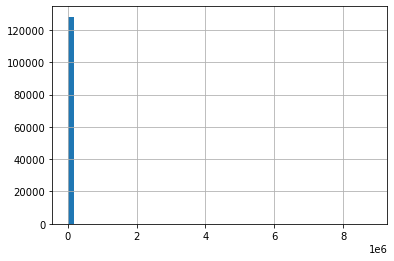

In [28]:
# TOT_EMP distribution
salary_df['TOT_EMP'].hist(bins=50);

From the plot nearly all the values are below 1,000,000. So what are these high values?

In [29]:
# Look at TOT_EMP values above one million
salary_df[['OCC_TITLE','O_GROUP','TOT_EMP','EMP_PRSE','JOBS_1000',
           'LOC_QUOTIENT']][salary_df.TOT_EMP > 1000000].reset_index(drop=True)

,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT
0,All Occupations,total,2632850.0,0.4,1000.000,1.00
1,All Occupations,total,1054230.0,0.7,1000.000,1.00
2,All Occupations,total,1287630.0,1.1,1000.000,1.00
3,All Occupations,total,1211240.0,0.7,1000.000,1.00
4,All Occupations,total,4362110.0,0.4,1000.000,1.00
5,All Occupations,total,1028260.0,0.7,1000.000,1.00
6,All Occupations,total,1026540.0,1.2,1000.000,1.00
7,All Occupations,total,3588450.0,0.4,1000.000,1.00
8,All Occupations,total,1457420.0,0.8,1000.000,1.00
9,All Occupations,total,1779580.0,0.8,1000.000,1.00


With the exception of Office and Administrative Support Occupations, the rest of these values are of all occupations. This is also apparent in the JOBS_1000 which the number of jobs (employment) in the given occupation per 1,000 jobs in the given area. Only available for the state and MSA estimates; otherwise, this column is blank. Each value is a 1,000 representing one hundred percent of jobs and location quotient is one which should also make senese since location quotient represents the share of location's total jobs with the value one meaning 100 percent of jobs. We can filter for title 'All Occupations' and look athe the distribution.  

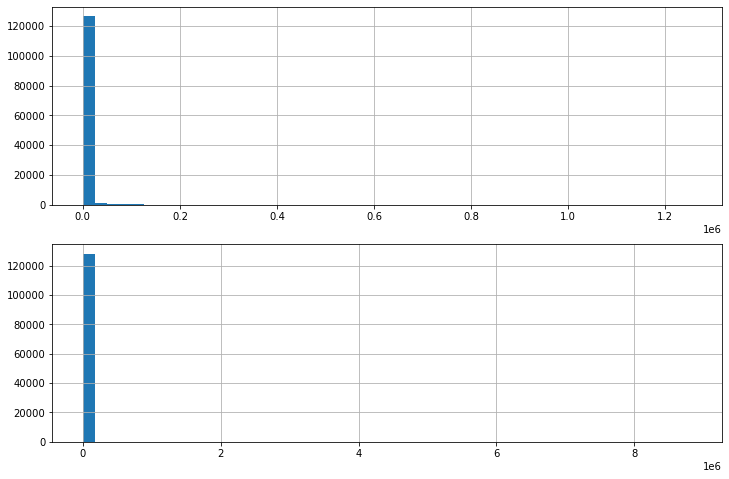

In [30]:
# Re plot TOT_EMP with and without 'All Occupations'

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
salary_df['TOT_EMP'][salary_df['OCC_TITLE'] != 'All Occupations'].hist(bins=50, ax=ax[0])

salary_df['TOT_EMP'].hist(bins=50, ax=ax[1]);

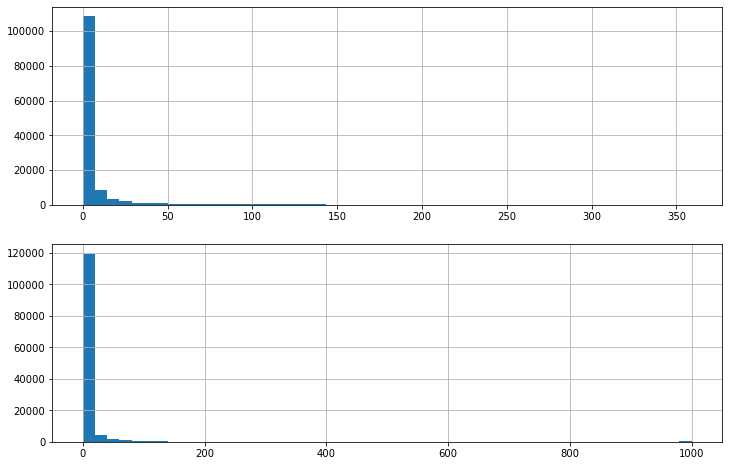

In [31]:
# Re-plot JOBS_1000

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
salary_df['JOBS_1000'][salary_df['OCC_TITLE'] != 'All Occupations'].hist(bins=50, ax=ax[0])

salary_df['JOBS_1000'].hist(bins=50, ax=ax[1]);

Still highly skewed! The max values are much lower but still quite high with respect to the most common values. 

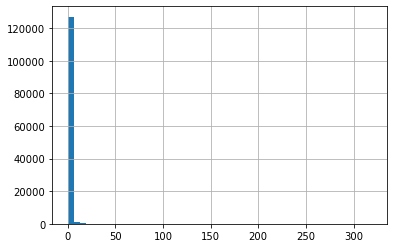

In [32]:
# LOC_QUOTIENT

salary_df['LOC_QUOTIENT'].hist(bins=50);

The LOC_QUOTIENT - represents the ratio of an occupation’s share of employment in a given area to that occupation’s share of employment in the U.S. as a whole. Only available for the state, metropolitan area, and nonmetropolitan area estimates; otherwise, this column is blank. A location quotient greater than one indicates the occupation has a higher share of employment than average, and a location quotient less than one indicates the occupation is less prevalent in the area than average.

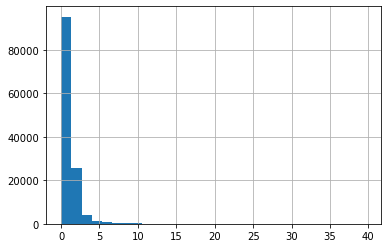

In [33]:
salary_df['LOC_QUOTIENT'][salary_df['LOC_QUOTIENT'] < 40].hist(bins=30);

Really high, though rare location quotients are possible if the location has a high concentration of that occuption. 

In [34]:
# Let's look at the highest LOC_QUOTIENT values to see what occupation and area they represent
salary_df[['AREA_TITLE','PRIM_STATE','OCC_TITLE','LOC_QUOTIENT']][salary_df[
    'LOC_QUOTIENT'] > 100].sort_values('LOC_QUOTIENT',ascending=False).reset_index(drop=True)

,AREA_TITLE,PRIM_STATE,OCC_TITLE,LOC_QUOTIENT
0,Dalton,GA,"Textile Winding, Twisting, and Drawing Out Mac...",319.37
1,Dalton,GA,"Textile Knitting and Weaving Machine Setters, ...",218.17
2,Houma-Thibodaux,LA,Sailors and Marine Oilers,166.24
3,Wheeling,WV,"Roof Bolters, Mining",129.65
4,Bremerton-Silverdale,WA,"Layout Workers, Metal and Plastic",115.51
5,Dalton,GA,"Extruding and Forming Machine Setters, Operato...",113.63
6,San German,PR,Sewing Machine Operators,103.87
7,Midland,TX,"Service Unit Operators, Oil and Gas",102.66
8,Hickory-Lenoir-Morganton,NC,"Cutters and Trimmers, Hand",100.93
9,Hickory-Lenoir-Morganton,NC,Upholsterers,100.27


Explore some of these for verification of numbers.

The relative standard error (RSE) is a measure of the reliability of a survey statistic. The smaller the relative standard error, the more precise the estimate.

Estimates for detailed occupations do not sum to the totals because the totals include occupations not shown separately. Estimates do not include self-employed workers.

Annual wages have been calculated by multiplying the hourly mean wage by a "year-round, full-time" hours figure of 2,080 hours; for those occupations where there is not an hourly wage published, the annual wage has been directly calculated from the reported survey data.

## Target features

We are interested in income by occupation for cities and metropolitan areas. Which value are we interested in? For each annual and hourly income estimates, there are columns for mean, median, 10th, 25th, 75th, and 90th percentiles. 

The percentile wage estimate is the value of a wage below which a certain percent of workers fall. The median wage is the 50th percentile wage estimate—50 percent of workers earn less than the median and 50 percent of workers earn more than the median.

### Hourly mean and annual mean

Hourly mean - Missing 6.6 percent; min=8.32, max=315830; IQR= 15.51; median=22.94; Mean=27.17

Annual mean - Missing 2 percent; min=17300, max=151.84; IQR= 33040; median=48560; Mean=57082

Both are skewed to the right which makes sense since the max value is so much larger than the median values. 

In [35]:
# Hourly and annual mean are both null 
missing = salary_df[(salary_df['H_MEAN'].isnull()) & (salary_df['A_MEAN'].isnull())]
missing

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,region
15,10180,Abilene,TX,119141,"Property, Real Estate, and Community Associati...",detailed,60.0,35.6,0.929,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
61,10180,Abilene,TX,211091,Health Education Specialists,detailed,40.0,14.7,0.680,1.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
68,10180,Abilene,TX,251011,"Business Teachers, Postsecondary",detailed,70.0,8.7,1.100,1.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
169,10180,Abilene,TX,413011,Advertising Sales Agents,detailed,30.0,39.2,0.527,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
195,10180,Abilene,TX,435021,Couriers and Messengers,detailed,60.0,27.9,0.849,1.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139781,79600,Worcester,MA,291248,"Surgeons, Except Ophthalmologists",detailed,130.0,36.1,0.486,1.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139802,79600,Worcester,MA,311132,Orderlies,detailed,100.0,7.0,0.389,1.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139875,79600,Worcester,MA,413031,"Securities, Commodities, and Financial Service...",detailed,500.0,38.8,1.886,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139881,79600,Worcester,MA,419022,Real Estate Sales Agents,detailed,60.0,26.2,0.213,0.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT


In [36]:
# Join with top_income earners which had their income as '#' representing all those earning above 
# $208,000 or $100 per hour
missing_top=missing.join(top_income, how='inner', lsuffix='_left', rsuffix='_right')
missing_top_index=missing_top.index

In [37]:
salary_df.loc[missing_top_index, ['OCC_TITLE', 'A_MEAN']]

,OCC_TITLE,A_MEAN
8750,"Surgeons, Except Ophthalmologists",NaN
16594,Anesthesiologists,NaN
17928,Anesthesiologists,NaN
21068,Anesthesiologists,NaN
21074,"Surgeons, Except Ophthalmologists",NaN
...,...,...
135424,Family Medicine Physicians,NaN
135425,"Physicians, All Other; and Ophthalmologists, E...",NaN
135964,Anesthesiologists,NaN
135968,"Surgeons, Except Ophthalmologists",NaN


In [38]:
salary_df.loc[missing_top_index, 'A_MEAN'] = 208000

In [39]:
salary_df['OCC_TITLE'][salary_df['A_MEAN']==208000].value_counts()

Surgeons, Except Ophthalmologists                                    38
Anesthesiologists                                                    32
Physicians, All Other; and Ophthalmologists, Except Pediatric        11
Obstetricians and Gynecologists                                       9
General Internal Medicine Physicians                                  6
Orthodontists                                                         4
Psychiatrists                                                         4
Dentists, General                                                     2
Family Medicine Physicians                                            2
Oral and Maxillofacial Surgeons                                       2
Agents and Business Managers of Artists, Performers, and Athletes     1
Dentists, All Other Specialists                                       1
Name: OCC_TITLE, dtype: int64

In [40]:
salary_df.loc[missing_top_index, 'H_MEAN'] = 100

In [41]:
salary_df['OCC_TITLE'][salary_df['H_MEAN'] == 100].value_counts()

Surgeons, Except Ophthalmologists                                    38
Anesthesiologists                                                    32
Physicians, All Other; and Ophthalmologists, Except Pediatric        11
Obstetricians and Gynecologists                                       9
General Internal Medicine Physicians                                  6
Orthodontists                                                         4
Psychiatrists                                                         4
Dentists, General                                                     2
Family Medicine Physicians                                            2
Oral and Maxillofacial Surgeons                                       2
Agents and Business Managers of Artists, Performers, and Athletes     1
Dentists, All Other Specialists                                       1
Name: OCC_TITLE, dtype: int64

We do have actual reported values for many instances of some of the above occupations (see below)!

In [42]:
salary_df['OCC_TITLE'][(salary_df['A_MEAN'] > 208000) | (salary_df['H_MEAN'] > 100)].value_counts()

Physicians, All Other; and Ophthalmologists, Except Pediatric                    283
Family Medicine Physicians                                                       165
Chief Executives                                                                  87
General Internal Medicine Physicians                                              73
Surgeons, Except Ophthalmologists                                                 72
Dentists, General                                                                 69
Psychiatrists                                                                     63
Obstetricians and Gynecologists                                                   47
Anesthesiologists                                                                 28
Pediatricians, General                                                            23
Nurse Anesthetists                                                                16
Airline Pilots, Copilots, and Flight Engineers                   

In [43]:
still_missing = salary_df[(salary_df['H_MEAN'].isnull()) & (salary_df['A_MEAN'].isnull())]
still_missing

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,region
15,10180,Abilene,TX,119141,"Property, Real Estate, and Community Associati...",detailed,60.0,35.6,0.929,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
61,10180,Abilene,TX,211091,Health Education Specialists,detailed,40.0,14.7,0.680,1.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
68,10180,Abilene,TX,251011,"Business Teachers, Postsecondary",detailed,70.0,8.7,1.100,1.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
169,10180,Abilene,TX,413011,Advertising Sales Agents,detailed,30.0,39.2,0.527,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
195,10180,Abilene,TX,435021,Couriers and Messengers,detailed,60.0,27.9,0.849,1.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139781,79600,Worcester,MA,291248,"Surgeons, Except Ophthalmologists",detailed,130.0,36.1,0.486,1.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139802,79600,Worcester,MA,311132,Orderlies,detailed,100.0,7.0,0.389,1.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139875,79600,Worcester,MA,413031,"Securities, Commodities, and Financial Service...",detailed,500.0,38.8,1.886,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139881,79600,Worcester,MA,419022,Real Estate Sales Agents,detailed,60.0,26.2,0.213,0.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT


In [44]:
still_missing.value_counts('OCC_TITLE')

OCC_TITLE
Legislators                                                   46
Business Teachers, Postsecondary                              36
Lawyers                                                       35
Health Specialties Teachers, Postsecondary                    34
Legal Occupations                                             32
                                                              ..
Dining Room and Cafeteria Attendants and Bartender Helpers     1
Dietitians and Nutritionists                                   1
Dietetic Technicians                                           1
Detectives and Criminal Investigators                          1
Writers and Authors                                            1
Length: 577, dtype: int64

In [45]:
# How many in H_MEAN?
salary_df['H_MEAN'].isnull().sum()

9172

In [46]:
# Percent H_MEAN null
salary_df['H_MEAN'].isnull().mean()*100

6.549042848676553

In [47]:
# How many null values in A_MEAN now?
salary_df['A_MEAN'].isnull().sum()

2736

In [48]:
# Percent A_MEAN null
salary_df['A_MEAN'].isnull().mean()*100

1.9535740551656182

Both values have 112 fewer values as they should since top income earners from earlier have 112 records. We were only able to fill in values for 0.05 percent of the null in A_MEAN and H_MEAN

In [49]:
still_missing.isnull().sum()
# The rest income related values are also missing for these occupations

AREA               0
AREA_TITLE         0
PRIM_STATE         0
OCC_CODE           0
OCC_TITLE          0
O_GROUP            0
TOT_EMP            0
EMP_PRSE           0
JOBS_1000          0
LOC_QUOTIENT       0
H_MEAN          2562
A_MEAN          2562
MEAN_PRSE       2562
H_PCT10         2562
H_PCT25         2562
H_MEDIAN        2562
H_PCT75         2562
H_PCT90         2562
A_PCT10         2562
A_PCT25         2562
A_MEDIAN        2562
A_PCT75         2562
A_PCT90         2562
region             0
dtype: int64

In [50]:
100*2562/140051

1.8293335999028926

Still missing both hourly and annual means for 577 unique occupations and 2,562 values or 1.8 percent. In fact it appears all information regarding income amount is missing for these rows. 

In [51]:
all_missing = salary_df.loc[still_missing.index, ['H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90',
                                                 'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90' ]]

In [52]:
all_missing.isnull().sum()

H_PCT10     2562
H_PCT25     2562
H_MEDIAN    2562
H_PCT75     2562
H_PCT90     2562
A_PCT10     2562
A_PCT25     2562
A_MEDIAN    2562
A_PCT75     2562
A_PCT90     2562
dtype: int64

In [53]:
means_missing = salary_df[(salary_df['H_MEAN'].isnull()) | (salary_df['A_MEAN'].isnull())]
means_missing

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,region
12,10180,Abilene,TX,119032,"Education Administrators, Kindergarten through...",detailed,150.0,4.5,2.295,1.22,...,NaN,NaN,NaN,NaN,55830.0,63640.0,74800.0,87090.0,106570.0,TX
15,10180,Abilene,TX,119141,"Property, Real Estate, and Community Associati...",detailed,60.0,35.6,0.929,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
61,10180,Abilene,TX,211091,Health Education Specialists,detailed,40.0,14.7,0.680,1.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
68,10180,Abilene,TX,251011,"Business Teachers, Postsecondary",detailed,70.0,8.7,1.100,1.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
71,10180,Abilene,TX,252012,"Kindergarten Teachers, Except Special Education",detailed,40.0,5.7,0.587,0.68,...,NaN,NaN,NaN,NaN,34640.0,41410.0,46350.0,51300.0,59340.0,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139797,79600,Worcester,MA,299091,Athletic Trainers,detailed,70.0,16.3,0.248,1.26,...,NaN,NaN,NaN,NaN,42370.0,46470.0,52840.0,62090.0,74420.0,MA-CT
139802,79600,Worcester,MA,311132,Orderlies,detailed,100.0,7.0,0.389,1.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139875,79600,Worcester,MA,413031,"Securities, Commodities, and Financial Service...",detailed,500.0,38.8,1.886,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT
139881,79600,Worcester,MA,419022,Real Estate Sales Agents,detailed,60.0,26.2,0.213,0.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MA-CT


## Missing values

From the report's matrix we can see that TOT_EMP, EMP_PRSE, JOBS_1000 and LOC_QUOTIENT have the same null values since they are all relevent to employment numbers. 11,658 and 8.3 percent of values area missing for each field. 

In [54]:
# Filter for the 'detailed' O_GROUP category to get rid of all values for aggregates of job types
salary = salary_df[salary_df['O_GROUP'] == 'detailed'].reset_index(drop=True)
salary

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,region
0,10180,Abilene,TX,111021,General and Operations Managers,detailed,1320.0,7.4,20.036,1.19,...,24.02,32.96,50.11,72.93,26350.0,49960.0,68550.0,104230.0,151700.0,TX
1,10180,Abilene,TX,112022,Sales Managers,detailed,90.0,18.5,1.317,0.47,...,35.90,52.41,68.01,NaN,54560.0,74680.0,109000.0,141460.0,NaN,TX
2,10180,Abilene,TX,112030,Public Relations and Fundraising Managers,detailed,40.0,31.5,0.549,0.94,...,32.78,36.24,41.23,83.81,59710.0,68180.0,75380.0,85760.0,174320.0,TX
3,10180,Abilene,TX,113010,Administrative Services and Facilities Managers,detailed,140.0,12.3,2.045,0.92,...,28.28,35.06,45.45,55.25,51850.0,58820.0,72920.0,94530.0,114920.0,TX
4,10180,Abilene,TX,113021,Computer and Information Systems Managers,detailed,70.0,30.2,1.054,0.32,...,35.72,56.28,71.04,97.75,54690.0,74310.0,117060.0,147760.0,203330.0,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131005,79600,Worcester,MA,537063,Machine Feeders and Offbearers,detailed,180.0,17.5,0.660,1.43,...,14.31,16.11,20.42,24.29,27770.0,29770.0,33500.0,42470.0,50530.0,MA-CT
131006,79600,Worcester,MA,537064,"Packers and Packagers, Hand",detailed,1220.0,21.6,4.592,1.07,...,13.42,14.68,16.60,19.62,26780.0,27910.0,30540.0,34530.0,40800.0,MA-CT
131007,79600,Worcester,MA,537065,Stockers and Order Fillers,detailed,4300.0,4.5,16.161,1.02,...,13.65,14.99,18.13,22.65,26810.0,28400.0,31170.0,37700.0,47100.0,MA-CT
131008,79600,Worcester,MA,537081,Refuse and Recyclable Material Collectors,detailed,100.0,16.6,0.388,0.45,...,15.67,22.92,27.45,30.28,27900.0,32580.0,47680.0,57090.0,62980.0,MA-CT


In [55]:
# Keep AREA_TITLE, PRIM_STATE, OCC_TITLE, A_MEAN and H_MEAN
salary = salary[['AREA_TITLE', 'PRIM_STATE', 'OCC_CODE','OCC_TITLE', 'A_MEAN', 'H_MEAN']]

In [56]:
salary.head()

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN
0,Abilene,TX,111021,General and Operations Managers,83990.0,40.38
1,Abilene,TX,112022,Sales Managers,121020.0,58.18
2,Abilene,TX,112030,Public Relations and Fundraising Managers,95540.0,45.93
3,Abilene,TX,113010,Administrative Services and Facilities Managers,78600.0,37.79
4,Abilene,TX,113021,Computer and Information Systems Managers,123040.0,59.15


## O'NET data on skills

In [57]:
#Read skills information for occupations into a dataframe
skills_df = pd.read_excel('../data/raw/Skills.xlsx')

In [58]:
skills_df.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.75,8.0,0.16,4.43,5.07,N,N,07/2014,Analyst
2,11-1011.00,Chief Executives,2.A.1.b,Active Listening,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
3,11-1011.00,Chief Executives,2.A.1.b,Active Listening,LV,Level,4.88,8.0,0.23,4.43,5.32,N,N,07/2014,Analyst
4,11-1011.00,Chief Executives,2.A.1.c,Writing,IM,Importance,4.00,8.0,0.00,4.00,4.00,N,NaN,07/2014,Analyst


In [59]:
# Clean up O*NET-SOC Code column 
skills_df.columns

Index(['O*NET-SOC Code', 'Title', 'Element ID', 'Element Name', 'Scale ID',
       'Scale Name', 'Data Value', 'N', 'Standard Error', 'Lower CI Bound',
       'Upper CI Bound', 'Recommend Suppress', 'Not Relevant', 'Date',
       'Domain Source'],
      dtype='object')

In [60]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   57400 non-null  float64
 8   Standard Error      57400 non-null  float64
 9   Lower CI Bound      57400 non-null  float64
 10  Upper CI Bound      57400 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


In [61]:
# Clean O*NET-SOC Code column and convert to integer index so we can joing with the bls data
skills_df['O*NET-SOC Code'] = skills_df['O*NET-SOC Code'].str.replace('-','')

In [62]:
skills_df['O*NET-SOC Code'] = skills_df['O*NET-SOC Code'].str.split('.', expand=True)

In [63]:
skills_df['O*NET-SOC Code'] = skills_df['O*NET-SOC Code'].apply(pd.to_numeric)

In [64]:
skills_importance = skills_df[skills_df['Scale Name'] == 'Importance'].reset_index(drop=True)
skills_importance = skills_importance[['O*NET-SOC Code', 'Title', 'Element Name', 'Data Value']]
skills_importance = skills_importance.rename(columns = {'O*NET-SOC Code':'OCC_CODE'})
skills_importance.head()

,OCC_CODE,Title,Element Name,Data Value
0,111011,Chief Executives,Reading Comprehension,4.12
1,111011,Chief Executives,Active Listening,4.12
2,111011,Chief Executives,Writing,4.00
3,111011,Chief Executives,Speaking,4.38
4,111011,Chief Executives,Mathematics,3.25


In [65]:
skills_level = skills_df[skills_df['Scale Name'] == 'Level'].reset_index(drop=True)
skills_level = skills_level[['O*NET-SOC Code', 'Title', 'Element Name', 'Data Value']]
skills_level = skills_level.rename(columns = {'O*NET-SOC Code':'OCC_CODE'})

skills_level.head()

,OCC_CODE,Title,Element Name,Data Value
0,111011,Chief Executives,Reading Comprehension,4.75
1,111011,Chief Executives,Active Listening,4.88
2,111011,Chief Executives,Writing,4.38
3,111011,Chief Executives,Speaking,4.88
4,111011,Chief Executives,Mathematics,3.62


In [66]:
salary_importance = salary.merge(skills_importance, on = 'OCC_CODE')
salary_importance.head()

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value
0,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Reading Comprehension,3.88
1,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Active Listening,4.00
2,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Writing,3.25
3,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Speaking,4.00
4,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Mathematics,2.38


In [67]:
salary_level = salary.merge(skills_level, on = 'OCC_CODE')
salary_level.head()

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value
0,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Reading Comprehension,4.00
1,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Active Listening,4.00
2,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Writing,3.88
3,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Speaking,4.00
4,Abilene,TX,111021,General and Operations Managers,83990.0,40.38,General and Operations Managers,Mathematics,2.50


In [68]:
salary_importance.shape

(4863250, 9)

In [69]:
salary_level.shape

(4863250, 9)

In [70]:
skills_importance.shape

(30555, 4)

In [71]:
skills_level.shape

(30555, 4)

In [72]:
salary.shape

(131010, 6)

In [73]:
salary_importance.isna().sum()

AREA_TITLE           0
PRIM_STATE           0
OCC_CODE             0
OCC_TITLE            0
A_MEAN           89250
H_MEAN          271635
Title                0
Element Name         0
Data Value           0
dtype: int64

In [74]:
salary_level.isna().sum()

AREA_TITLE           0
PRIM_STATE           0
OCC_CODE             0
OCC_TITLE            0
A_MEAN           89250
H_MEAN          271635
Title                0
Element Name         0
Data Value           0
dtype: int64

In [101]:
diffs = salary_importance[salary_importance['OCC_TITLE'] != salary_importance['Title']]
diffs = diffs.groupby(['OCC_TITLE','Title']).agg({'OCC_TITLE':'count'})

In [102]:
diffs

OCC_TITLE
OCC_TITLE                                          Title                                                        
Architectural and Engineering Managers             Biofuels/Biodiesel Technology and Product Devel...      10115
Biological Scientists, All Other                   Bioinformatics Scientists                                4305
                                                   Biologists                                               4305
                                                   Geneticists                                              4305
                                                   Molecular and Cellular Biologists                        4305
...                                                                                                          ...
Therapists, All Other                              Music Therapists                                         2135
Transportation Inspectors                          Aviation Inspectors                                      2695
                                                   Transportation Vehicle, Equipment and Systems I...       2695
Transportation, Storage, and Distribution Managers Supply Chain Managers                                   11060
Writers and Authors                                Poets, Lyricists and Creative Writers                    4690

[101 rows x 1 columns]

In [107]:
# Run a new roport
profile_report_all = salary_level.profile_report(html={'style': {'full_width': True}})
profile_report_all.to_file("../reports/level.html")
profile_report_all.to_widgets()

In [116]:
salary_level['Element Name'].value_counts()

Equipment Maintenance                138950
Technology Design                    138950
Writing                              138950
Systems Analysis                     138950
Mathematics                          138950
Operation and Control                138950
Speaking                             138950
Quality Control Analysis             138950
Time Management                      138950
Learning Strategies                  138950
Management of Financial Resources    138950
Management of Personnel Resources    138950
Programming                          138950
Social Perceptiveness                138950
Critical Thinking                    138950
Negotiation                          138950
Equipment Selection                  138950
Troubleshooting                      138950
Service Orientation                  138950
Instructing                          138950
Active Listening                     138950
Complex Problem Solving              138950
Repairing                       

In [132]:
salary_level[salary_level['A_MEAN'].isnull() & salary_level['H_MEAN'].isnull()].groupby('OCC_TITLE').count()

,AREA_TITLE,PRIM_STATE,OCC_CODE,A_MEAN,H_MEAN,Title,Element Name,Data Value
OCC_TITLE,,,,,,,,
Actors,385,385,385,0,0,385,385,385
Actuaries,140,140,140,0,0,140,140,140
"Adult Basic Education, Adult Secondary Education, and English as a Second Language Instructors",245,245,245,0,0,245,245,245
Advertising Sales Agents,420,420,420,0,0,420,420,420
Advertising and Promotions Managers,175,175,175,0,0,175,175,175
...,...,...,...,...,...,...,...,...
"Welders, Cutters, Solderers, and Brazers",35,35,35,0,0,35,35,35
"Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",70,70,70,0,0,70,70,70
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",70,70,70,0,0,70,70,70


In [137]:
salary_level[salary_level['A_MEAN'].isnull() & salary_level['H_MEAN']
             .isnull()].groupby('AREA_TITLE').count()

,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value
AREA_TITLE,,,,,,,,
Abilene,175,175,175,0,0,175,175,175
Aguadilla-Isabela,245,245,245,0,0,245,245,245
Akron,665,665,665,0,0,665,665,665
Albany,350,350,350,0,0,350,350,350
Albany-Schenectady-Troy,175,175,175,0,0,175,175,175
...,...,...,...,...,...,...,...,...
Yakima,105,105,105,0,0,105,105,105
York-Hanover,210,210,210,0,0,210,210,210
Youngstown-Warren-Boardman,455,455,455,0,0,455,455,455


In [138]:
both_null = salary_level[salary_level['A_MEAN'].isnull() & salary_level['H_MEAN'].isnull()]

In [140]:
# Delete the rows where both A_MEAN AND H_MEAN are null
salary_level.drop(both_null.index, inplace=True)

In [153]:
salary_level.shape

(4778200, 9)

In [158]:
# Percent of records deleted
(4863250-4778200)/4863250*100

1.7488305145735876

In [152]:
pd.concat([salary_level.isnull().sum(), 100 * salary_level.isnull().mean()], axis=1)

,0,1
AREA_TITLE,0,0.000000
PRIM_STATE,0,0.000000
OCC_CODE,0,0.000000
OCC_TITLE,0,0.000000
A_MEAN,4200,0.087899
H_MEAN,186585,3.904922
Title,0,0.000000
Element Name,0,0.000000
Data Value,0,0.000000


In [180]:
# Which occupations are missing annual mean values
salary_level['Title'][salary_level['A_MEAN'].isnull()].value_counts()

Musicians and Singers    2590
Actors                    945
Dancers                   665
Name: Title, dtype: int64

There are fewer values missing for A_MEAN than H_MEAN. Looks like there values are only for the three occupations Musicians and Singers, Actors, and Dancers. From the metadata we know that these occupations are among those with only hourly values reported, so should we use the hourly mean values to estimate an annual mean for these occupations? But these occupations also don't work the typical 40 hour weeks so can we do this?!

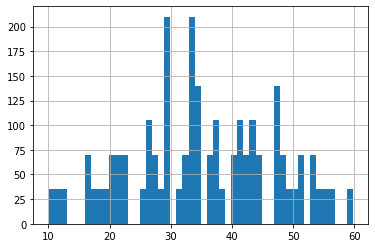

In [187]:
# Distribution of hourly mean for musicians and singers
salary_level['H_MEAN'][(salary_level['A_MEAN'].isnull()) & (salary_level['Title'] == 'Musicians and Singers')].hist(bins=50);

In [191]:
salary_level[(salary_level['A_MEAN'].notna()) & salary_level['Title'] == 'Musicians and Singers']

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value


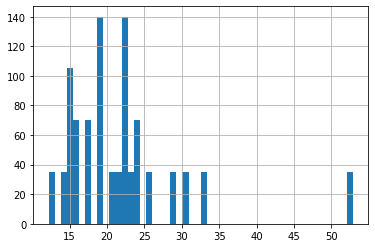

In [188]:
# Actors
salary_level['H_MEAN'][(salary_level['A_MEAN'].isnull()) & (salary_level['Title'] == 'Actors')].hist(bins=50);

In [192]:
salary_level[(salary_level['A_MEAN'].notna()) & salary_level['Title'] == 'Actors']

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value


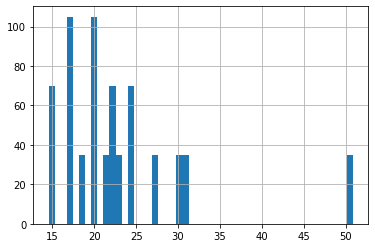

In [189]:
# Dancers
salary_level['H_MEAN'][(salary_level['A_MEAN'].isnull()) & (salary_level['Title'] == 'Dancers')].hist(bins=50);

In [193]:
salary_level[(salary_level['A_MEAN'].notna()) & salary_level['Title'] == 'Dancers']

,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,A_MEAN,H_MEAN,Title,Element Name,Data Value
